In [1]:
is_skip = True

# Data params
batch_size = 512
encode_len = 60
pred_len = 30

valid_start_date = "2020-01-01"

# Model params
d_model = 128
nhead = 2
d_ff = 128
dropout = 0.0
num_layers = 2

# Import

In [2]:
import joblib
import copy
import time

from tqdm import tqdm
from IPython.display import clear_output
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from transformers import BertConfig, BertTokenizer, BertModel
from pytorch_model_summary import summary

device = torch.device("cuda:0")
# device = torch.device("cpu")

/home/sh-sungho.park/anaconda3/envs/cudatest/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Data

### Read

In [3]:
if not is_skip:
    # Read transaction
    df_trans = pd.read_csv("../HnM/transactions_train.csv", parse_dates=["t_dat"], dtype={"article_id":str})
    df_meta = pd.read_csv("../HnM/articles.csv", dtype={"article_id":str})
    df_raw = pd.merge(df_trans, df_meta, on="article_id")

In [4]:
def preprocess(data, df_meta, is_train=True):
    data = data.copy()
    static_cols = ["prod_name", "product_type_name", "product_group_name", "graphical_appearance_name", "colour_group_name", "perceived_colour_value_name", "perceived_colour_master_name", "department_name", "index_name", "index_group_name", "section_name", "garment_group_name"]

   # Make sales
    data = data.groupby(["t_dat", "article_id", *static_cols], as_index=False).agg(sales=("customer_id", "count"), price=("price", "mean"))
    data["size"] = data.groupby(["article_id"], as_index=False)["sales"].transform("count")
    data = data[data["size"] >=50]

   # Expand dates
    data = data.set_index("t_dat").groupby(["article_id"], as_index=False).resample("1D").asfreq().reset_index()
    data["sales"] = data["sales"].fillna(0)
    data["price"] = data["price"].fillna(method="ffill")
    data["article_id"] = data["article_id"].fillna(method="ffill")
    data = data.sort_values(["article_id", "t_dat"])

    # Make time idx
    data["time_idx"] = data.groupby(["article_id"]).transform("cumcount")

   # Shift
    data["shift3"] = data["sales"].shift(3)
    data["shift7"] = data["sales"].shift(7)
    data["shift30"] = data["sales"].shift(30)
    data = data.dropna()

   # Temporal information
   # Make sure the sequence start from 0
    data["day"] = data["t_dat"].dt.day - 1
    data["dow"] = data["t_dat"].dt.dayofweek
    data["month"] = data["t_dat"].dt.month - 1
    data["year"] = data["t_dat"].dt.year - data["t_dat"].dt.year.min()
    
   # Data to list
    data = data.groupby("article_id", as_index=False)[["sales", "price", "shift3", "shift7", "shift30", "time_idx"] + ["day", "dow", "month", "year"]].agg(list)

   # Size restriction
    data["size"] = data["sales"].str.len()

   # Output
    return data, static_cols

if not is_skip:
    df_prep = df_raw[df_raw["index_name"] == "Ladieswear"]
    # df_prep = df_raw.copy()

    df_train = df_prep[df_prep["t_dat"] < valid_start_date]
    df_train, static_cols = preprocess(df_train, df_meta)
    df_train.to_parquet("df_train.pq")
    joblib.dump(static_cols, "static_cols.pkl")

    df_valid = df_prep[df_prep["t_dat"] >= valid_start_date]
    df_valid, _ = preprocess(df_valid, df_meta)
    df_valid.to_parquet("df_valid.pq")

### Dataset

In [5]:
df_train = pd.read_parquet("df_train.pq")
df_valid = pd.read_parquet("df_valid.pq")
df_train = df_train[df_train["size"] >= encode_len+pred_len]
df_valid = df_valid[df_valid["size"] >= encode_len+pred_len]

is_skip = False

class Dataset(torch.utils.data.Dataset):
    def __init__(self, data):
        self.sales_li, self.price_li, self.shift3_li, self.shift7_li, self.shift30_li, self.time_idx_li, self.relative_timeidx_li = [], [], [], [], [], [], []
        for _, row in tqdm(data.iterrows()):
            # Get data for each
            sales = row["sales"]
            price = row["price"]
            shift3, shift7, shift30 = row["shift3"], row["shift7"], row["shift30"]
            time_idx = row["time_idx"].copy()


            # Scale
            sales_scaler, time_idx_scaler = StandardScaler(), MinMaxScaler()
            sales = sales_scaler.fit_transform(sales.reshape(-1,1)).reshape(-1)
            shift3 = sales_scaler.transform(shift3.reshape(-1,1)).reshape(-1)
            shift7 = sales_scaler.transform(shift7.reshape(-1,1)).reshape(-1)
            shift30 = sales_scaler.transform(shift30.reshape(-1,1)).reshape(-1)
            relative_timeidx = time_idx_scaler.fit_transform(time_idx.reshape(-1,1)).reshape(-1)
            
            # Flod
            sales = torch.Tensor(sales).unfold(0, encode_len+pred_len, 1).numpy()
            price = torch.Tensor(price).unfold(0, encode_len+pred_len, 1).numpy()
            shift3 = torch.Tensor(shift3).unfold(0, encode_len+pred_len, 1).numpy()
            shift7 = torch.Tensor(shift7).unfold(0, encode_len+pred_len, 1).numpy()
            shift30 = torch.Tensor(shift30).unfold(0, encode_len+pred_len, 1).numpy()
            time_idx = torch.Tensor(time_idx).unfold(0, encode_len+pred_len, 1).numpy()
            relative_timeidx = torch.Tensor(relative_timeidx).unfold(0, encode_len+pred_len, 1).numpy()
        
            # Append
            self.sales_li.append(sales)
            self.price_li.append(price)
            self.shift3_li.append(shift3)
            self.shift7_li.append(shift7)
            self.shift30_li.append(shift30)
            self.time_idx_li.append(time_idx)
            self.relative_timeidx_li.append(relative_timeidx)
        
        # Finalize
        self.sales_li = np.concatenate(self.sales_li)
        self.price_li = np.concatenate(self.price_li)
        self.shift3_li = np.concatenate(self.shift3_li)
        self.shift7_li = np.concatenate(self.shift7_li)
        self.shift30_li = np.concatenate(self.shift30_li)
        self.time_idx_li = np.concatenate(self.time_idx_li)
        self.relative_timeidx_li = np.concatenate(self.relative_timeidx_li)
    
    def __len__(self):
        return self.sales_li.shape[0]

    def __getitem__(self, idx):
        sales = self.sales_li[idx]
        price = self.price_li[idx]
        shift3 = self.shift3_li[idx]
        shift7 = self.shift7_li[idx]
        shift30 = self.shift30_li[idx]
        time_idx = self.time_idx_li[idx]
        relative_timeidx_li = self.relative_timeidx_li[idx]
        idx_ref = np.arange(sales.shape[0])

        encoder_seq = np.stack([sales, price, shift3, shift7, shift30, time_idx, relative_timeidx_li], axis=-1)[:encode_len]
        decoder_seq = np.stack([time_idx, relative_timeidx_li], axis=-1)[-pred_len:]
        y = sales

        encoder_idx = idx_ref[:encode_len]
        decoder_idx = idx_ref[-pred_len:]
        
        return {"encoder_seq":encoder_seq, "deocder_seq":decoder_seq, "y":y, "encoder_idx":encoder_idx, "decoder_idx":decoder_idx}
    
if not is_skip:
    train_dataset = Dataset(df_train)
    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    valid = Dataset(df_valid)
    valid_dataloader = torch.utils.data.DataLoader(valid, batch_size=batch_size, shuffle=True)

    joblib.dump(train_dataloader, "train_dataloader.pkl")

train_dataloader = joblib.load("train_dataloader.pkl")
for data in train_dataloader:
    print("encoder_seq", data["encoder_seq"].shape)
    print("deocder_seq", data["deocder_seq"].shape)
    print("y", data["y"].shape)
    break

0it [00:00, ?it/s]/tmp/ipykernel_108738/1170176372.py:29: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /opt/conda/conda-bld/pytorch_1682343962757/work/torch/csrc/utils/tensor_numpy.cpp:206.)
  price = torch.Tensor(price).unfold(0, encode_len+pred_len, 1).numpy()
20246it [00:08, 2285.46it/s]
9823it [00:04, 2365.24it/s]


encoder_seq torch.Size([512, 60, 7])
deocder_seq torch.Size([512, 30, 2])
y torch.Size([512, 90])


# Architecture

### Helper

In [6]:
from torch.nn import functional as F

def _generate_square_subsequent_mask(sz, device, dtype):
    return torch.triu(
        torch.full((sz, sz), float('-inf'), dtype=dtype, device=device),
        diagonal=1,
    )

def _get_seq_len(src, batch_first):
    if src.is_nested:
        return None
    else:
        src_size = src.size()
        if len(src_size) == 2:
            # unbatched: S, E
            return src_size[0]
        else:
            # batched: B, S, E if batch_first else S, B, E
            seq_len_pos = 1 if batch_first else 0
            return src_size[seq_len_pos]

def _detect_is_causal_mask(mask, is_causal=None,size=None):
    # Prevent type refinement
    make_causal = (is_causal is True)

    if is_causal is None and mask is not None:
        sz = size if size is not None else mask.size(-2)
        causal_comparison = _generate_square_subsequent_mask(
            sz, device=mask.device, dtype=mask.dtype)

        # Do not use `torch.equal` so we handle batched masks by
        # broadcasting the comparison.
        if mask.size() == causal_comparison.size():
            make_causal = bool((mask == causal_comparison).all())
        else:
            make_causal = False

    return make_causal

class FeedForward(torch.nn.Module):
    def __init__(self, d_model, d_ff, activation):
        super().__init__()
        self.linear1 = torch.nn.Linear(d_model, d_ff)
        self.linear2 = torch.nn.Linear(d_ff, d_model)
        self.dropout = torch.nn.Dropout()

        if activation == "relu":
            self.activation = torch.nn.ReLU()

    def forward(self, x):
        x = self.linear2(self.dropout(self.activation(self.linear1(x))))
        return self.dropout(x)

class DecoderLayer(torch.nn.TransformerDecoderLayer):
    def forward(self, tgt, memory, tgt_mask=None, memory_mask=None, tgt_key_padding_mask=None, memory_key_padding_mask=None, tgt_is_causal=False, memory_is_causal=False):
        x = tgt
        if self.norm_first: raise
        else:
            self_attn_output, self_attn_weight = self._sa_block(x, tgt_mask, tgt_key_padding_mask, tgt_is_causal)
            x = self.norm1(x + self_attn_output)

            cross_attn_output, cross_attn_weight = self._mha_block(x, memory, memory_mask, memory_key_padding_mask, memory_is_causal)
            x = self.norm2(x + cross_attn_output)
            x = self.norm3(x + self._ff_block(x))
        return x, self_attn_weight, cross_attn_weight

    # self-attention block
    def _sa_block(self, x, attn_mask, key_padding_mask, is_causal=False):
        x, self_attn_weight = self.self_attn(x, x, x,
                           attn_mask=attn_mask,
                           key_padding_mask=key_padding_mask,
                           is_causal=is_causal,
                           need_weights=True)
        return self.dropout1(x), self_attn_weight

    # multihead attention block
    def _mha_block(self, x, mem, attn_mask, key_padding_mask, is_causal=False):
        x, cross_attn_weight = self.multihead_attn(x, mem, mem,
                                attn_mask=attn_mask,
                                key_padding_mask=key_padding_mask,
                                is_causal=is_causal,
                                need_weights=True)
        return self.dropout2(x), cross_attn_weight

class Decoder(torch.nn.TransformerDecoder):
    def forward(self, tgt, memory, tgt_mask=None, memory_mask=None, tgt_key_padding_mask=None, memory_key_padding_mask=None, tgt_is_causal=None, memory_is_causal=False):
        output = tgt

        seq_len = _get_seq_len(tgt, self.layers[0].self_attn.batch_first)
        tgt_is_causal = _detect_is_causal_mask(tgt_mask, tgt_is_causal, seq_len)

        for mod in self.layers:
            output, self_attn_weight, cross_attn_weight = mod(output, memory, tgt_mask=tgt_mask,
                                                            memory_mask=memory_mask,
                                                            tgt_key_padding_mask=tgt_key_padding_mask,
                                                            memory_key_padding_mask=memory_key_padding_mask,
                                                            tgt_is_causal=tgt_is_causal,
                                                            memory_is_causal=memory_is_causal)

        if self.norm is not None:
            output = self.norm(output)

        return output, self_attn_weight, cross_attn_weight

class EncoderLayer(torch.nn.TransformerEncoderLayer):
    def forward(self, src, src_mask=None, src_key_padding_mask=None, is_causal=False):
        x = src
        attn_output, attn_weight = self._sa_block(x, src_mask, src_key_padding_mask, is_causal=is_causal)
        x = self.norm1(x + attn_output)
        x = self.norm2(x + self._ff_block(x))

        return x, attn_weight

    # self-attention block
    def _sa_block(self, x, attn_mask, key_padding_mask, is_causal=False):
        x, attn_weight = self.self_attn(x, x, x,
                           attn_mask=attn_mask,
                           key_padding_mask=key_padding_mask,
                           need_weights=True, is_causal=is_causal)
        return self.dropout1(x), attn_weight

class Encoder(torch.nn.TransformerEncoder):
    def forward(self, src, mask=None, src_key_padding_mask=None, is_causal=None):
       ################################################################################################################
        src_key_padding_mask = F._canonical_mask(
            mask=src_key_padding_mask,
            mask_name="src_key_padding_mask",
            other_type=F._none_or_dtype(mask),
            other_name="mask",
            target_type=src.dtype
        )

        mask = F._canonical_mask(
            mask=mask,
            mask_name="mask",
            other_type=None,
            other_name="",
            target_type=src.dtype,
            check_other=False,
        )

        output = src
        convert_to_nested = False
        first_layer = self.layers[0]
        src_key_padding_mask_for_layers = src_key_padding_mask
        why_not_sparsity_fast_path = ''
        str_first_layer = "self.layers[0]"
        batch_first = first_layer.self_attn.batch_first
        if not hasattr(self, "use_nested_tensor"):
            why_not_sparsity_fast_path = "use_nested_tensor attribute not present"
        elif not self.use_nested_tensor:
            why_not_sparsity_fast_path = "self.use_nested_tensor (set in init) was not True"
        elif first_layer.training:
            why_not_sparsity_fast_path = f"{str_first_layer} was in training mode"
        elif not src.dim() == 3:
            why_not_sparsity_fast_path = f"input not batched; expected src.dim() of 3 but got {src.dim()}"
        elif src_key_padding_mask is None:
            why_not_sparsity_fast_path = "src_key_padding_mask was None"
        elif (((not hasattr(self, "mask_check")) or self.mask_check)
                and not torch._nested_tensor_from_mask_left_aligned(src, src_key_padding_mask.logical_not())):
            why_not_sparsity_fast_path = "mask_check enabled, and src and src_key_padding_mask was not left aligned"
        elif output.is_nested:
            why_not_sparsity_fast_path = "NestedTensor input is not supported"
        elif mask is not None:
            why_not_sparsity_fast_path = "src_key_padding_mask and mask were both supplied"
        elif torch.is_autocast_enabled():
            why_not_sparsity_fast_path = "autocast is enabled"

        if not why_not_sparsity_fast_path:
            tensor_args = (
                src,
                first_layer.self_attn.in_proj_weight,
                first_layer.self_attn.in_proj_bias,
                first_layer.self_attn.out_proj.weight,
                first_layer.self_attn.out_proj.bias,
                first_layer.norm1.weight,
                first_layer.norm1.bias,
                first_layer.norm2.weight,
                first_layer.norm2.bias,
                first_layer.linear1.weight,
                first_layer.linear1.bias,
                first_layer.linear2.weight,
                first_layer.linear2.bias,
            )
            _supported_device_type = ["cpu", "cuda", torch.utils.backend_registration._privateuse1_backend_name]
            if torch.overrides.has_torch_function(tensor_args):
                why_not_sparsity_fast_path = "some Tensor argument has_torch_function"
            elif src.device.type not in _supported_device_type:
                why_not_sparsity_fast_path = f"src device is neither one of {_supported_device_type}"
            elif torch.is_grad_enabled() and any(x.requires_grad for x in tensor_args):
                why_not_sparsity_fast_path = ("grad is enabled and at least one of query or the "
                                              "input/output projection weights or biases requires_grad")

            if (not why_not_sparsity_fast_path) and (src_key_padding_mask is not None):
                convert_to_nested = True
                output = torch._nested_tensor_from_mask(output, src_key_padding_mask.logical_not(), mask_check=False)
                src_key_padding_mask_for_layers = None

        seq_len = _get_seq_len(src, batch_first)
        is_causal = _detect_is_causal_mask(mask, is_causal, seq_len)
       ################################################################################################################

        for mod in self.layers:
            output, attn_weight = mod(output, src_mask=mask, is_causal=is_causal, src_key_padding_mask=src_key_padding_mask_for_layers)

        if convert_to_nested:
            output = output.to_padded_tensor(0., src.size())

        if self.norm is not None:
            output = self.norm(output)

        return output, attn_weight

### Transformer

In [7]:
class Transformer(torch.nn.Module):
    def __init__(self, d_model, num_layers, nhead, d_ff, dropout):
        super().__init__()
        self.encoder_lstm = torch.nn.LSTM(7, d_model, batch_first=True)
        self.decoder_lstm = torch.nn.LSTM(2, d_model, batch_first=True)
        self.encoder = Encoder(EncoderLayer(d_model, nhead, d_ff, dropout=dropout, batch_first=True), num_layers)

        self.linear = torch.nn.Linear(d_model, 1)

    def forward(self, encoder_seq, decoder_seq):
        encoder_seq, hidden = self.encoder_lstm(encoder_seq)
        decoder_seq = self.decoder_lstm(decoder_seq, hidden)[0]

        concat_input = torch.concat([encoder_seq, decoder_seq], dim=1)
        encoder_output, input_input_attn = self.encoder(concat_input)

        output = self.linear(encoder_output)

        return output.squeeze(-1), input_input_attn


model = Transformer(d_model, num_layers, nhead, d_ff, dropout)
model.to(device)
summary(model,
        data["encoder_seq"].to(device),
        data["deocder_seq"].to(device),
        show_parent_layers=True, print_summary=True)

--------------------------------------------------------------------------------------------------------------------
   Parent Layers       Layer (type)                                     Output Shape         Param #     Tr. Param #
     Transformer             LSTM-1     [512, 60, 128], [1, 512, 128], [1, 512, 128]          70,144          70,144
     Transformer             LSTM-2     [512, 30, 128], [1, 512, 128], [1, 512, 128]          67,584          67,584
     Transformer          Encoder-3                    [512, 90, 128], [512, 90, 90]         199,168         199,168
     Transformer           Linear-4                                     [512, 90, 1]             129             129
Total params: 337,025
Trainable params: 337,025
Non-trainable params: 0
--------------------------------------------------------------------------------------------------------------------


'--------------------------------------------------------------------------------------------------------------------\n   Parent Layers       Layer (type)                                     Output Shape         Param #     Tr. Param #\n====================================================================================================================\n     Transformer             LSTM-1     [512, 60, 128], [1, 512, 128], [1, 512, 128]          70,144          70,144\n     Transformer             LSTM-2     [512, 30, 128], [1, 512, 128], [1, 512, 128]          67,584          67,584\n     Transformer          Encoder-3                    [512, 90, 128], [512, 90, 90]         199,168         199,168\n     Transformer           Linear-4                                     [512, 90, 1]             129             129\n====================================================================================================================\nTotal params: 337,025\nTrainable params: 337,025\nNon-t

# Train

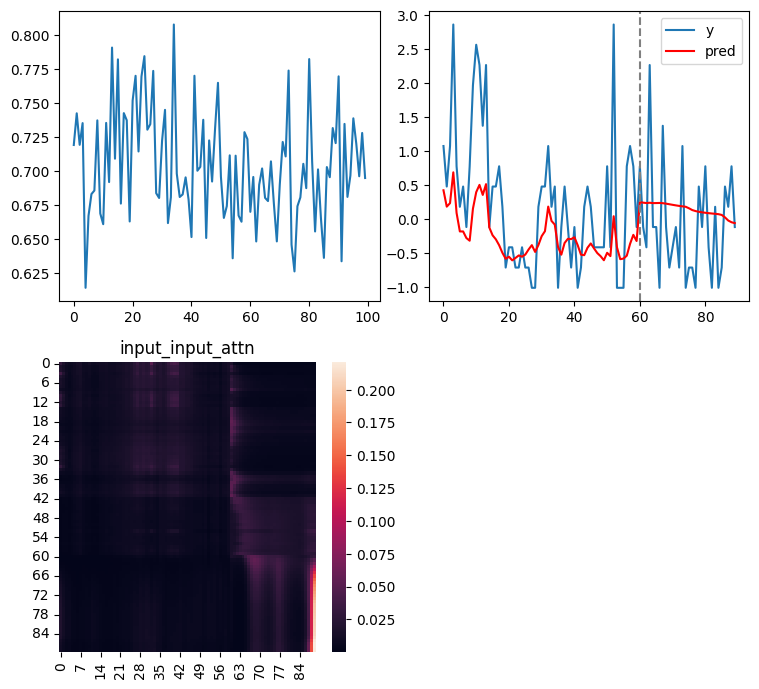

0 - loss: 0.702713793516159 , lr: 0.001:  72%|███████▏  | 2097/2913 [01:05<00:21, 37.16it/s] 

In [8]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.998)
mse_loss = torch.nn.MSELoss()
mse_loss_full = torch.nn.MSELoss(reduction="none")

def output_loss_func(pred, y):
    loss = mse_loss_full(pred, y)
    cheating_loss = torch.mean(loss[:, :-pred_len])
    real_loss = torch.mean(loss[:, -pred_len:])

    return cheating_loss, real_loss

def train(e):
    pbar = tqdm(train_dataloader)
    loss_li, cheating_loss_li, real_loss_li = [], [], []
    window = 100

    for n, data in enumerate(pbar):
        model.train()
        optimizer.zero_grad()
        pred, input_input_attn = model(
                                    data["encoder_seq"].to(device),
                                    data["deocder_seq"].to(device),
                                        )
        cheating_loss, real_loss = output_loss_func(pred, data["y"].to(device))
        loss = real_loss
        loss_li.append(loss.item())
        loss.backward()
        optimizer.step()
        pbar.set_description(f"{e} - loss: {np.mean(loss_li[-window:])} , lr: {optimizer.param_groups[0]['lr']}")

        if n % 20 == 0:
            plt.figure(figsize=(15,7))
            nrows, ncols = 2, 4
            clear_output(wait=True)
            plt.subplot(nrows, ncols, 1)
            plt.plot(loss_li[-window:])

            plt.subplot(nrows, ncols, 2)
            df_y = pd.DataFrame({"y":data["y"][-1]}).reset_index()
            df_pred = pd.DataFrame({"pred":pred[-1].detach().cpu().numpy()}).reset_index()
            
            df_res = pd.merge(df_y, df_pred, on="index", how="outer")

            plt.plot(df_res["y"], label="y")
            plt.plot(df_res["pred"], label="pred", color="red")
            plt.axvline(encode_len, linestyle="--", color="gray")
            plt.legend()

            plt.subplot(nrows, ncols, 5)
            sns.heatmap(input_input_attn[-1].detach().cpu())
            plt.title("input_input_attn")

            # plt.subplot(nrows, ncols, 6)
            # sns.heatmap(diff_hist_attn[-1].detach().cpu())
            # plt.title("diff_hist_attn")

            # plt.subplot(nrows, ncols, 7)
            # sns.heatmap(out_out_attn[-1].detach().cpu())
            # plt.title("out_out_attn")

            # plt.subplot(nrows, ncols, 8)
            # sns.heatmap(out_hist_attn[-1].detach().cpu())
            # plt.title("out_hist_attn")

            plt.tight_layout()
            plt.show()


epoch = 10
for e in range(epoch):
    train(e)
    scheduler.step()